In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
import seaborn as sns
from econml.dml import LinearDML
from scipy.special import expit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [18]:
np.random.seed(34)

df = pd.DataFrame(columns = ['Confounder', 'Treatment', 'Outcome'])
df['Confounder'] = np.random.normal(loc = 100, scale=25, size = 1000)
df['Treatment'] = np.random.normal(loc = 50, scale = 10, size = 1000) + 0.5 * df['Confounder']
df['Outcome'] = 0.25 * df['Confounder'] + 0.75 * df['Treatment'] + np.random.normal(loc=0, scale=5, size=1000)

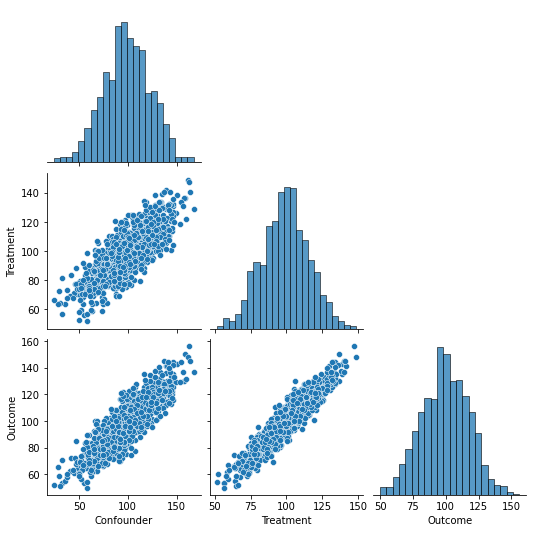

In [19]:
sns.pairplot(df, corner = True)
plt.show()

In [20]:
y = df['Outcome']
X = df[['Confounder', 'Treatment']]

model = RidgeCV()
model = model.fit(X, y)

ate_lr = round(model.coef_[1], 2)

print(f'The average treatment effect using Linear Regression is: {ate_lr}')

The average treatment effect using Linear Regression is: 0.75


In [29]:
treatment = df['Treatment'].to_numpy().reshape(-1, 1)
outcome = df['Outcome'].to_numpy().reshape(-1, 1)
confounder = df['Confounder'].to_numpy().reshape(-1, 1)

In [32]:
treatment_model = RidgeCV()
treatment_model = treatment_model.fit(confounder, treatment)
treatment_pred = treatment_model.predict(confounder)
treatment_residuals = treatment - treatment_pred

outcome_model = RidgeCV()
outcome_model = outcome_model.fit(confounder, outcome)
outcome_pred = outcome_model.predict(confounder)
outcome_residuals = outcome - outcome_pred

final_model = RidgeCV()
final_model = final_model.fit(treatment_residuals, outcome_residuals)
ate_fwl = round(final_model.coef_[0][0], 2)

print(f'The average treatment effect is: {ate_fwl}')

The average treatment effect is: 0.75


In [40]:
dml = LinearDML(discrete_treatment = False)
dml.fit(df['Outcome'].to_numpy().reshape(-1,1), T=df['Treatment'].to_numpy().reshape(-1,1), X=None, W=df['Confounder'].to_numpy().reshape(-1,1))

ate_dml = round(dml.ate()[0], 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


The average treatment effect using the DML is: 0.75


### Complicated Nuisance Function

In [43]:
np.random.seed(123)

n=100000

p=10

X = np.random.uniform(size = n*p).reshape((n,-1))

b = (
    np.sin(np.pi * X[:, 0] * X[:, 1])
    + 2 * (X[:, 2] - 0.5) ** 2
    + X[:, 3]
    + 0.5 * X[:, 4]
    + X[:, 5] * X[:, 6]
    + X[:, 7] ** 3
    + np.sin(np.pi * X[:, 8] * X[:, 9])    
)

T = np.random.binomial(1, expit(b))

tau = 0.75

y = b + T * tau + np.random.normal(size = n)

In [53]:
X_T = np.append(X, T.reshape(-1, 1), axis = 1)


model = RidgeCV()
model = model.fit(X_T, y)
y_pred = model.predict(X_T)

ate_lr = round(model.coef_[-1], 2)

print(f'The average treatment effect with LR is {ate_lr}')

The average treatment effect with LR is 0.85


### Using DML

In [60]:
np.random.seed(123)

dml = LinearDML(model_y = RandomForestRegressor(), model_t=RandomForestClassifier(), discrete_treatment=True)
dml.fit(y, T=T, X=None, W=X)

ate_dml = round(dml.ate(), 2)

print(f'The average treatment effect using the DML is: {ate_dml}')

The average treatment effect using the DML is: 0.76


### EconML

### Residual

In [63]:
model = RandomForestRegressor()

In [73]:
model.fit(X_T, y)

RandomForestRegressor()

In [74]:
y_hat = model.predict(X_T)

In [75]:
clf = RandomForestClassifier()
clf.fit(X_T, T)

t_hat = clf.predict(X_T)

In [76]:
residual_y = y - y_hat
residual_t = T - t_hat

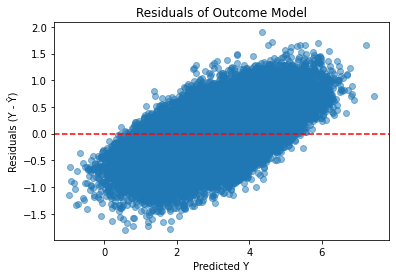

In [82]:
import matplotlib.pyplot as plt

# Residuals for Y
plt.figure()
plt.scatter(y_hat, residual_y, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals of Outcome Model")
plt.xlabel("Predicted Y")
plt.ylabel("Residuals (Y - Ŷ)")
plt.show()

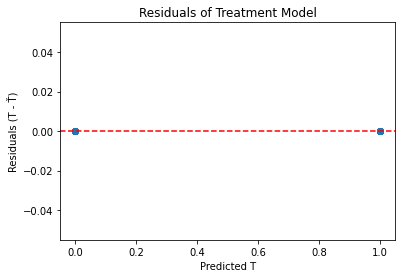

In [83]:
# Residuals for T
plt.figure()
plt.scatter(t_hat, residual_t, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals of Treatment Model")
plt.xlabel("Predicted T")
plt.ylabel("Residuals (T - Ť)")
plt.show()